# 1 Introduction

There are three parts to our script as follows:

* Feature engineering
* Missing value imputation
* Prediction!

## 1.1 Setting up the environment

In [1]:
# Import packages

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from CustomDataFrame import CustomDataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from statsmodels.graphics.mosaicplot import mosaic
from tabulate import tabulate

In [2]:
# Set figsize for plots
plt.rcParams['figure.figsize'] = (8, 5)

# Set random state
random_state = 754

## 1.2 Loading data

Now that our packages are loaded, let’s read in and take a peek at the data.

In [3]:
# Read data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

# Concatenate training & test data
full = pd.concat([train, test], ignore_index=True)

Authors here use df.info() method to print out the most important info about the data. That approach however does not make it easy to see clearly which columns have missing values that have to be taken care of.   
For this purpose, a class `CustomDataFrame` is created, that lists Null Count, instead of Non-Null:

In [4]:
# Custom DataFrame info
print(CustomDataFrame(full))

Rows: 1309, Columns: 12

+---------------+-------------+--------------+
| Column Name   | Data Type   | Null Count   |
|---------------+-------------+--------------|
| PassengerId   | int64       | 0 (0.0%)     |
| Survived      | float64     | 418 (31.9%)  |
| Pclass        | int64       | 0 (0.0%)     |
| Name          | object      | 0 (0.0%)     |
| Sex           | object      | 0 (0.0%)     |
| Age           | float64     | 263 (20.1%)  |
| SibSp         | int64       | 0 (0.0%)     |
| Parch         | int64       | 0 (0.0%)     |
| Ticket        | object      | 0 (0.0%)     |
| Fare          | float64     | 1 (0.1%)     |
| Cabin         | object      | 1014 (77.5%) |
| Embarked      | object      | 2 (0.2%)     |
+---------------+-------------+--------------+


As we can see, columns containing missing values are:  
* Survived (**y** variable)
* Age
* Fare
* Cabin
* Embarked

The column **Cabin** contains 77.5% missing values, so there is no smart way to impute 3/4 of missing values, column has to be dropped altogether.     
However, the **Survived** variable contains missing values as well. They cannot be imputed as well, because doing so will lead to some bias in the data, making them more noisy or causing some sort of target leakage, depending on the chosen imputation method.    
Other variables can be imputed because of the low frequency of Nulls, but first of all, all missing **Survived** observations has to be removed before any other feature engineering.

In [5]:
full = full.loc[~full['Survived'].isna()]

print(CustomDataFrame(full))

Rows: 891, Columns: 12

+---------------+-------------+--------------+
| Column Name   | Data Type   | Null Count   |
|---------------+-------------+--------------|
| PassengerId   | int64       | 0 (0.0%)     |
| Survived      | float64     | 0 (0.0%)     |
| Pclass        | int64       | 0 (0.0%)     |
| Name          | object      | 0 (0.0%)     |
| Sex           | object      | 0 (0.0%)     |
| Age           | float64     | 177 (19.9%)  |
| SibSp         | int64       | 0 (0.0%)     |
| Parch         | int64       | 0 (0.0%)     |
| Ticket        | object      | 0 (0.0%)     |
| Fare          | float64     | 0 (0.0%)     |
| Cabin         | object      | 687 (77.1%)  |
| Embarked      | object      | 2 (0.2%)     |
+---------------+-------------+--------------+


Now we have only 891 observations, but missing values are now in columns:
* Age
* Cabin
* Embarked

The one missing value from **Fare** has been dropped by removing null **Survived**.  
Contrary to the original Notebook, that created a **Deck** variable out of **Cabin**, here the **Cabin** is dropped.  
**Age** and **Embarked** columns will have their values imputed by their medians (**Age**) or most frequent value (**Embarked**).  
  
The key difference is the imputation method. Authors use a predictive imputation method, which sounds like a good idea, but maybe not in this dataset. Author's approach is really messy, feature engineering process leaves many legacy columns in the data, increasing the computation complexity.  
Another point is that author tried to impute a column with more than 3/4 values missing, while the best idea would be to drop it.  
Finally, author uses predictive imputation with Random Forest Regression without stating the random state, making the process not possible to reproduce fully. Our approach, on the other hand, does not contain any randomness, so it's easily reproducible.

In [6]:
# Drop the Cabin columns
full.drop('Cabin', axis = 1, inplace = True)

# Define the variables to impute
variables_to_impute = ['Age', 'Embarked']

# Perform SimpleImputation on defined variables
imputer = SimpleImputer(strategy='most_frequent')
imputed_values = imputer.fit_transform(full[variables_to_impute])

# Crate a DataFrame with new values
imputed_df = pd.DataFrame(imputed_values, columns = variables_to_impute)

# Impute the missing values
full.loc[:, variables_to_impute] = full.loc[:, variables_to_impute].fillna(imputed_df)

# Print new DataFrame info
print(CustomDataFrame(full))

Rows: 891, Columns: 11

+---------------+-------------+--------------+
| Column Name   | Data Type   | Null Count   |
|---------------+-------------+--------------|
| PassengerId   | int64       | 0 (0.0%)     |
| Survived      | float64     | 0 (0.0%)     |
| Pclass        | int64       | 0 (0.0%)     |
| Name          | object      | 0 (0.0%)     |
| Sex           | object      | 0 (0.0%)     |
| Age           | object      | 0 (0.0%)     |
| SibSp         | int64       | 0 (0.0%)     |
| Parch         | int64       | 0 (0.0%)     |
| Ticket        | object      | 0 (0.0%)     |
| Fare          | float64     | 0 (0.0%)     |
| Embarked      | object      | 0 (0.0%)     |
+---------------+-------------+--------------+


# 2 Feature Engineering

## 2.1 PassengerId

That column does not carry any prediction power, it is simply the row index + 1. It is dropped entirely.

In [7]:
full.drop('PassengerId', axis = 1, inplace = True)

## 2.2 What’s in a name?

In [8]:
# Grab title from passenger names
name_split = full['Name'].apply(lambda x: x.split(','))
title_split = name_split.apply(lambda x: x[1].split('.')[0].strip())
full['Title'] = title_split

# Drop legacy column
full.drop('Name', axis = 1, inplace = True)

# Show title counts by sex
pd.crosstab(full['Sex'], full['Title'])

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0


In [9]:
# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'the Countess', 'Capt', 'Col', 'Don',
              'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
full.loc[full['Title'] == 'Mlle', 'Title'] = 'Miss'
full.loc[full['Title'] == 'Ms', 'Title'] = 'Miss'
full.loc[full['Title'] == 'Mme', 'Title'] = 'Mrs'
full.loc[full['Title'].isin(rare_title), 'Title'] = 'Rare Title'

# Show title counts by sex again
pd.crosstab(full['Sex'], full['Title'])

Title,Master,Miss,Mr,Mrs,Rare Title
Sex,,,,,
female,0,185,0,126,3
male,40,0,517,0,20


## 2.2 Do families sink or swim together?

Now that we've taken care of splitting passenger name into some new variables, we can take it a step further and make some new family variables. First we're going to make a **family size** variable based on number of siblings/spouse(s) (maybe someone has more than one spouse?) and number of children/parents. 


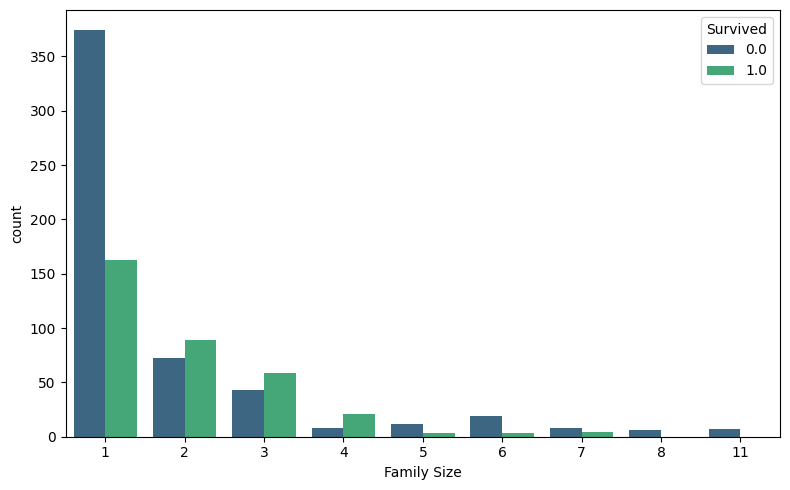

In [10]:
# Create a family size variable including the passenger themselves
full['Fsize'] = full['SibSp'] + full['Parch'] + 1

# Filter the data for visualization
filtered_data = full.loc[:890]  # Adjust the range if needed

# Use seaborn to visualize the relationship between family size and survival
sns.countplot(x='Fsize', hue='Survived', data=filtered_data, palette='viridis')

# Set plot labels and layout
plt.xlabel('Family Size')
plt.tight_layout()

# Display the plot
plt.show()

Ah hah. We can see that there's a survival penalty to singletons and those with family sizes above 4. We can collapse this variable into three levels which will be helpful since there are comparatively fewer large families. Let's create a **discretized family size** variable.


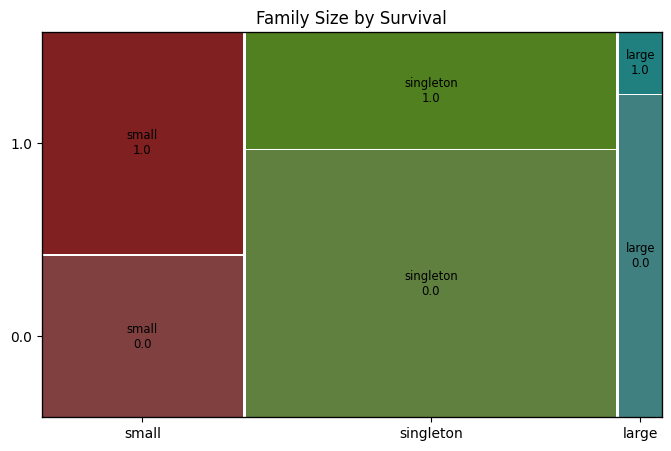

In [11]:
# Discretize family size into categories
full.loc[full['Fsize'] == 1, 'FsizeD'] = 'singleton'
full.loc[(full['Fsize'] < 5) & (full['Fsize'] > 1), 'FsizeD'] = 'small'
full.loc[full['Fsize'] > 4, 'FsizeD'] = 'large'

# Filter the data for visualization
filtered_data = full.loc[:890]  # Adjust the range if needed

# Create a mosaic plot to show the relationship between family size and survival
mosaic(filtered_data, ['FsizeD', 'Survived'], title='Family Size by Survival')

# Display the plot
plt.show()

## 2.3 Dummyfication

Here Author creates some visualizations and dummy variables, but for some reason some binary variables (**Mother**, **Child**, **Sex**) have string values instead of integers. Our process is simplified.

### 2.3.1 Child

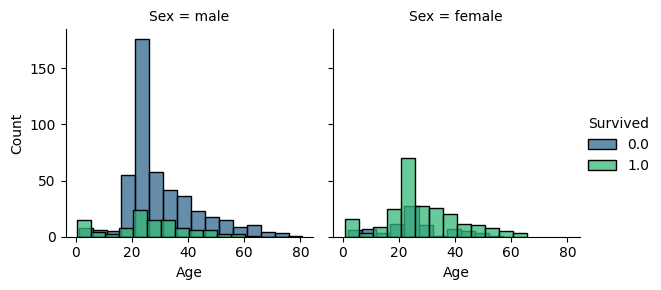

In [12]:
# Plot the relationship between age and survival
# Create a FacetGrid
grid = sns.FacetGrid(full[:891], col='Sex', hue='Survived', palette='viridis')

# Add a histogram to the grid
_ = grid.map_dataframe(sns.histplot, x='Age', multiple="stack", binwidth=5)

# Add a legend to the grid
_ = grid.add_legend()

In [13]:
# Create the column child, and indicate whether child or adult
full.loc[full['Age'] < 18, 'Child'] = 1
full.loc[full['Age'] >= 18, 'Child'] = 0

# Show counts
pd.crosstab(full['Child'], full['Survived'])

Survived,0.0,1.0
Child,,
0.0,497,281
1.0,52,61


### 2.3.2 Mother

In [14]:
# Add a 'Mother' variable based on specific conditions
full.loc[
    (full['Sex'] == 'female') &
    (full['Parch'] > 0) &
    (full['Age'] > 18) &
    (full['Title'] != 'Miss'),
    'Mother'] = 1

# Fill missing values in 'Mother' variable
full['Mother'].fillna(0, inplace=True)

# Show the counts of survival by the 'Mother' variable
pd.crosstab(full['Mother'], full['Survived'])

Survived,0.0,1.0
Mother,,
0.0,533,303
1.0,16,39


### 2.3.3 Sex

One binary variable `Male` is creted out of it.

In [15]:
# Create a dummy variable == 1 if 'male', 0 otherwise

full['Male'] = (full['Sex'] == 'male').astype(int)

### 2.3.4 Removing unneccesary variables

To keep code clear, the unncessesary columns are dropped right now.

In [16]:
# Define variables to be dropped
variables_to_drop = ['Sex', 'SibSp', 'Parch', 'Ticket', 'Fsize']

# Drop variables from the DataFrame
full.drop(variables_to_drop, axis = 1, inplace = True)

### 2.3.5 Creating dummies

Improved process allowed to decrease the number of dummified variables, thus cardinality of the model.  
Author's approach lead to creating dummies such as **Sex_Female**, **Sex_Male**, **Child_Child**, **Child_Adult** and so on, which is nonsense.  
Process is also done now without a loop.

In [17]:
# One Hot Encoding

# Create a copy of the dataset
encoded_data = full.copy()

# List of columns to encode (will be useful for modelling according to authors)
columns_to_encode = ['Pclass', 'Embarked', 'Title', 'FsizeD']

# Create dummy variables out of those columns
encoded_data = pd.get_dummies(encoded_data, columns = columns_to_encode, dtype = int)

# 4. Prediction

Author uses here `Random Forest` classification algorithm. That is ok, but random state has to be declared to ensure reproducibility.  
We also want to implement a robustness check - a cross-validation on the training subset.

## 4.1 Creating train, validation and test sets

In [18]:
# Split the data into train and test sets
train = encoded_data[:623]
test = encoded_data[623:]

# Split the train and test sets into X (features) and y (target)
X_train = train.drop('Survived', axis=1)
y_train = train["Survived"]

X_test = test.drop('Survived', axis=1)
y_test = test['Survived']

## 4.2 Cross-validation

In [19]:
cv_score = np.mean(
    cross_val_score(
    estimator = RandomForestClassifier(random_state = random_state),
    X = X_train,
    y = y_train,
    scoring = 'accuracy',
    cv = 5
    )
)

print(f"5-fold cross-validation accuracy score: {cv_score:.2f}")

5-fold cross-validation accuracy score: 0.81
